In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from scipy.interpolate import interp1d
import math


In [14]:
# SETUP

image = cv2.imread('001_1_1.bmp')


test = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# LOCALIZATION

test = cv2.GaussianBlur(test,(15,15), 0)
edges = cv2.Canny(test,50,100)
pupil = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,2, minDist = 70,
                            param2=50,minRadius=20,maxRadius=60)


pupil = np.uint16(np.around(pupil))
for value in pupil[0,:]:
    center_x = value[0]
    center_y = value[1]
    radius = value[2]
pupil = np.array([center_x, center_y, radius])

base = np.zeros_like(test)
mask_pupil = cv2.circle(base, (pupil[0], pupil[1]), pupil[2], (255,255,255), -1)
mask_pupil = cv2.bitwise_not(mask_pupil)
result = cv2.bitwise_and(test, mask_pupil)
mask_background = cv2.circle(base, (pupil[0], pupil[1]), pupil[2]*3, (255,255,255), -1)
result = cv2.bitwise_and(result, mask_background)

test = cv2.equalizeHist(result)
test = cv2.GaussianBlur(test,(25,25),0)


edges = cv2.Canny(test, 40, 70)
iris = cv2.HoughCircles(edges,cv2.HOUGH_GRADIENT,2,minDist = 1000,
                            param2=10,minRadius=pupil[2]+20,maxRadius=((pupil[2]*3)-10))

iris = np.uint16(np.around(iris))
for value in iris[0,:]:
    iris_x = value[0]
    iris_y = value[1]
    radius = value[2]
iris = np.array([center_x, center_y, radius])


# cv2.circle(image,(iris[0],iris[1]),iris[2],color = (0,255, 0), thickness = 2)
# cv2.circle(image,(pupil[0],pupil[1]),pupil[2],color = (0,255, 0), thickness = 2)

base = np.zeros_like(image)
mask_pupil = cv2.circle(base, (pupil[0], pupil[1]), pupil[2], (255,255,255), -1)
mask_pupil = cv2.bitwise_not(mask_pupil)
result = cv2.bitwise_and(image, mask_pupil)
mask_iris = cv2.circle(base, (iris[0], iris[1]), iris[2], (255,255,255), -1)
result = cv2.bitwise_and(result, mask_iris)
print(result.shape)

# Added code - this just reframes the image to center around iris to prevent wavy normalized iris

# same as iris_x and iris_y
x = int(iris[0])
y = int(iris[1])

w = int(iris[2])
h = int(iris[2])
print(x,y,w,h)


# when x + w > 320 which is the size of the image, there is an error
# if result.shape[1] > 319:
#     final = result[(y - h) : (y + h) - 2, (x - w) : (x + w)]
# else:
#     final = result[(y - h) : (y + h), (x - w) : (x + w)]
    
# final = result[(y - h) : (y + h), (x - w) : (x + w)]

# result2 = cv2.resize(result, (result.shape[1]*2, result.shape[0]*2))
# print(result2.shape)

final = result[iris[1] - iris[2] : iris[1] + iris[2], iris[0] - iris[2] : iris[0] + iris[2]]

# final = cv2.resize(final, (final.shape[1]*2, final.shape[0]*2))

# if final.shape[0] != final.shape[1]:
    
#     print(final.shape)

# final2 = cv2.resize(final, (final.shape[1]*2, final.shape[0]*2))

# print(final2.shape)

# cv2.imshow('detected circles',final)
# cv2.waitKey(0)

# TODO: fix incapable shape sizes
# image is wavy when final.shape 0 and 1 are not equal 



(280, 320, 3)
181 135 101 101


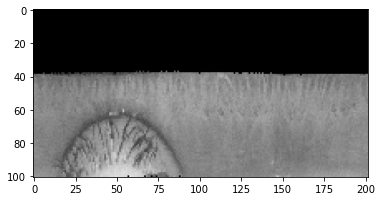

In [15]:
# NORMALIZATION
# adapted from https://github.com/prafulsurve/IrisDetection


theta = np.arange(0.00, np.pi * 2, 0.01) #array of columns in final image (goes to 6.28 because period is 2 pi)
r = np.arange(0, int(final.shape[0] / 2), 1) #array of rows in final image

cartesian_img = np.empty(shape = [r.size, int(final.shape[1]), 3]) # empty array of dimensions of final image

m = interp1d([np.pi * 2, 0],[0, final.shape[1]]) #interpolate location on x axis
    # interpolation between x = values from 0 and 6.28 and y = 0 to width of final image

# calculate all pixel values for normalized cartesian image 
for i in r:
    for j in theta:
        # x = rcos(theta)
        polarX = int((i * np.cos(j)) + final.shape[1] / 2)
        # y = rsin(theta)
        polarY = int((i * np.sin(j)) + final.shape[0] / 2)
        
        cartesian_img[i][int(m(j) - 1)] = final[polarY][polarX]


cartesian_img = cartesian_img.astype('uint8')
img = np.asarray(cartesian_img)
plt.imshow(img)

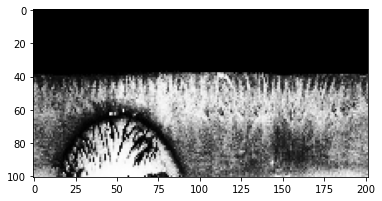

In [16]:
# ENHANCEMENT 

test = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
test = cv2.equalizeHist(test)
enhanced = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
plt.imshow(enhanced)
